recordings zip link = https://drive.google.com/file/d/1_Pry2orOFMDoK1IH9tSk-NKUAj-LxHs3/view?usp=sharing
Note=I downloaded the above zip file and uploaded it on my drive for preprocessing.  
My code drive link = https://drive.google.com/drive/folders/1andyrXRs0UhxIVgIgzBMBzjiiGj-Oy7D?usp=sharing

# 23100044
# Haseeb ur Rehman Faheem 

In [3]:
!pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=1a4ec60063904dfb3874fbbc2c0f353ac07d1471a0ae6c8753833d5ea2657383
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features


In [4]:
import python_speech_features as mfcc
from scipy.io.wavfile import read
import numpy as np
import glob 
from google.colab import drive
import glob


In [5]:
def get_MFCC(audio, sr):
    features = mfcc.mfcc(audio, sr, 0.025, 0.01, 13, appendEnergy = True)
    return np.mean(features, axis=0)

In [6]:
drive.mount('/content/drive')
!unzip -o -q "/content/drive/MyDrive/Recordings.zip" -d "/content/data/"


Mounted at /content/drive


Preprocessing for 5 classes, Englist, Urdu, Saraiki, Mixed and Punjabi.

In [7]:

audio = []
sr = []
files = []
y = []
for i in glob.glob("/content/data/Recordings/*.wav"):
  eachword = (i.split('/')[4])
  eachword= eachword.split('-')[0]
  if eachword == 'en':
    y.append(0)
  elif eachword == 'ur':
     y.append(1)
  elif eachword == 'si':
    y.append(2)
  elif eachword == 'ue':
    y.append(3)
  elif eachword == 'pn':
    y.append(4)
  else:
    print("eachword")
  sr1,audio1 = read(i)
  audio.append(audio1)
  sr.append(sr1)
    
print("Number of clips = ",len(audio))



Number of clips =  800


One-hot encoding

In [8]:

y = np.array(y)
y = y.astype(int)

def indices_to_one_hot(data, nb_classes):
    """Convert an iterable of indices to one-hot encoded labels."""
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets]

Y = indices_to_one_hot(y,5)

print(Y.shape)


(800, 5)


Concatenating 1 for bias

In [9]:
features = []
for i in audio:
  features.append(get_MFCC(i,16000))
features = np.array(features) 
a = np.ones((800,1))
features = np.hstack((a,features))


In [10]:
print(features.shape)

(800, 14)


Random Split of test and train datasets

In [11]:
testx = []
testy = []
trainx = []
trainy = []


random = np.random.permutation(800)

for i in random[:640]: 
  trainx.append(features[i])
  trainy.append(Y[i])
for i in random[640:]:
  testx.append(features[i])
  testy.append(Y[i])

trainy = np.array(trainy)
trainx = np.array(trainx)
testx = np.array(testx)
testy = np.array(testy)

print("Trainx shape = ",trainx.shape)
print("Trainy shape = ",testx.shape)

Trainx shape =  (640, 14)
Trainy shape =  (160, 14)


Softmax function

In [12]:
def softmax(vector):
  out_array = np.exp(vector)
  answer = []
  den = np.sum(out_array,axis=1,keepdims=True)
  return out_array/den
  


def forward_pass(a,b):
  return np.dot(a,b)

Cross Entropy Loss Function

In [13]:
def cross_entropy(x,y,w):
  value = 0.0000
  soft_max = softmax(forward_pass(x,w))
  value = -np.multiply(y,np.log(soft_max)) 

  return np.mean(value)



Batch Gradient Descent Function

In [14]:
def batch_gradient_descent(X,Y,alpha,epoch):

  theeta = np.ones((14,5)) * 0.01
  m = X.shape[0]
  j = []
  for n_epoch in range(epoch):
    temp_theeta=[]
    Y_ = softmax(forward_pass(X,theeta))
    derivatives = np.dot(X.T,Y_-Y)  
    theeta = theeta - ((alpha*derivatives)/m)
    j.append(cross_entropy(X,Y,theeta))
      # for k in range(0,len(theeta)):
      #   theeta[k] = theeta[k] - temp_theeta[k]
      
  return theeta,j



Testing on train dataset


Cross entropy loss error =  [0.1466294778078444]


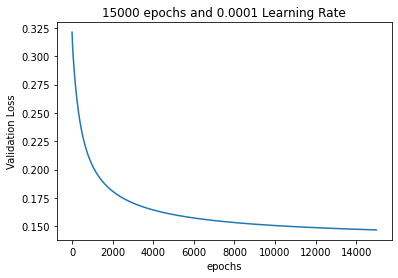

In [15]:
weights,error = batch_gradient_descent(trainx,trainy,0.0001,15000)
print("Cross entropy loss error = ",error[-1:])
from matplotlib import pyplot as plt
plt.title("15000 epochs and 0.0001 Learning Rate")
plt.xlabel("epochs")
plt.ylabel("Validation Loss")
plt.plot([i for i in range(15000)],error)

Cross entropy loss error =  [0.1377399982736633]


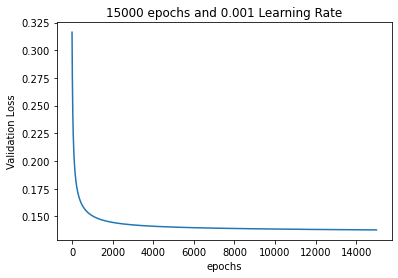

In [16]:
weights,error = batch_gradient_descent(trainx,trainy,0.001,15000)
print("Cross entropy loss error = ",error[-1:])
from matplotlib import pyplot as plt
plt.title("15000 epochs and 0.001 Learning Rate")
plt.xlabel("epochs")
plt.ylabel("Validation Loss")
plt.plot([i for i in range(15000)],error)

Cross entropy loss error =  [0.13662126316191814]


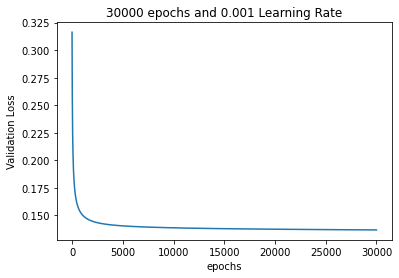

In [20]:
weights,error = batch_gradient_descent(trainx,trainy,0.001,30000)

print("Cross entropy loss error = ",error[-1:])
from matplotlib import pyplot as plt
plt.title("30000 epochs and 0.001 Learning Rate")
plt.xlabel("epochs")
plt.ylabel("Validation Loss")
plt.plot([i for i in range(30000)],error)

Predict Function and calculating accuracy on the test dataset

In [21]:

def predict(X,weights):
  y_ = softmax(forward_pass(X,weights))
  return np.argmax(y_,axis=1)
  
y_ = predict(testx,weights)
accuracy = 0
testy = testy.astype(int)
for i in range(0,len(y_)):
  if testy[i][y_[i]] == 1:
    accuracy +=1

  
accuracy = accuracy/len(y_)


Confusion Matrix, Accuracy and Macro f1 score  

In [22]:
import pandas as pd
def matrix(predicted,actual):
    y_actu = pd.Series(actual, name='Actual')
    y_pred = pd.Series(predicted, name='Predicted')

    df_confusion = pd.crosstab(y_actu, y_pred)
    df_conf_norm = df_confusion / df_confusion.sum(axis=1)
    df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
    print(df_confusion)
def f1(actual, predicted, label):

    """ A helper function to calculate f1-score for the given `label` """

    # F1 = 2 * (precision * recall) / (precision + recall)
    tp = np.sum((actual==label) & (predicted==label))
    fp = np.sum((actual!=label) & (predicted==label))
    fn = np.sum((predicted!=label) & (actual==label))
    if tp == 0 or fn == 0:
        tp +=1
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

def f1_macro(actual, predicted):
    # `macro` f1- unweighted mean of f1 per label
    return np.mean([f1(actual, predicted, label) 
        for label in np.unique(actual)])
    
f1_macro = f1_macro(y_,np.argmax((testy),axis=1))
# print(y_)
# print(np.argmax((testy),axis=1))
print("CONFUSION MATRIX")
matrix(y_,np.argmax((testy),axis=1))
print("\n\nAccuracy on test dataset = ", round(accuracy,3))
print("MACRO F-1 Score on test dataset = ",round(f1_macro,3))



CONFUSION MATRIX
Predicted   0   1   2   3   4  All
Actual                            
0          16  10   0   6   1   33
1           8  13   0   9   0   30
2           0   1  16   0   0   17
3           5   9   0  40   1   55
4           2   0   0   0  23   25
All        31  33  16  55  25  160


Accuracy on test dataset =  0.675
MACRO F-1 Score on test dataset =  0.706


Precision and Recall of all the classes 

In [23]:
def precision_recall(actual, predicted, label):

    """ A helper function to calculate f1-score for the given `label` """

    # F1 = 2 * (precision * recall) / (precision + recall)
    tp = np.sum((actual==label) & (predicted==label))
    fp = np.sum((actual!=label) & (predicted==label))
    fn = np.sum((predicted!=label) & (actual==label))
    if tp == 0 or fn == 0:
        tp +=1
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return precision,recall
precision1,recall1 = precision_recall(y_,np.argmax((testy),axis=1),0)
precision2,recall2 = precision_recall(y_,np.argmax((testy),axis=1),1)
precision3,recall3 = precision_recall(y_,np.argmax((testy),axis=1),2)
precision4,recall4 = precision_recall(y_,np.argmax((testy),axis=1),3)
precision5,recall5 = precision_recall(y_,np.argmax((testy),axis=1),4)


print("Precision of English = " ,round(precision1,3)  , "Recall of English = " ,round(recall1,3))
print("Precision of Urdu = " ,round(precision2,3)  , "Recall of Urdu = " ,round(recall2,3))
print("Precision of Seraiki = " ,round(precision3,3)  , "Recall of Seraiki = " ,round(recall3,3))
print("Precision of Mixed = " ,round(precision4,3)  , "Recall of Mixed = " ,round(recall4,3))
print("Precision of Punjabi = " ,round(precision5,3)  , "Recall of Punjabi = " ,round(recall5,3))


Precision of English =  0.485 Recall of English =  0.516
Precision of Urdu =  0.433 Recall of Urdu =  0.394
Precision of Seraiki =  0.944 Recall of Seraiki =  1.0
Precision of Mixed =  0.727 Recall of Mixed =  0.727
Precision of Punjabi =  0.92 Recall of Punjabi =  0.92


PART 2 using SKLEARN Logistic regression, accuracy score and confusion matrix function.

In [24]:
from sklearn.metrics import accuracy_score as a_s, confusion_matrix as c_m
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix



Splitting the train and test datasets randomly and not doing any one-hot encoding

In [25]:

testx1 = []
testy1 = []
trainx1 = []
trainy1 = []

random = np.random.permutation(800)

for i in random[:640]: 
  trainx1.append(features[i])
  trainy1.append(y[i])
for i in random[640:]:
  testx1.append(features[i])
  testy1.append(y[i])

trainy1 = np.array(trainy1)
trainx1 = np.array(trainx1)
testx1 = np.array(testx1)
testy1 = np.array(testy1)

print("Shape of trainx = ",trainx1.shape)
print("Shape of trainy = ",trainy1.shape)

Shape of trainx =  (640, 14)
Shape of trainy =  (640,)


In [36]:
lreg = LogisticRegression(max_iter= 10000)
lreg.fit(trainx1,trainy1)
predicted = lreg.predict(testx1)
print("Accuracy = ",accuracy_score(predicted,testy1))

confusion_matrix(predicted,testy1)

Accuracy =  0.66875


array([[21,  4,  0,  4,  0],
       [14, 14,  0,  1,  0],
       [ 0,  0, 18,  0,  0],
       [16, 14,  0, 35,  0],
       [ 0,  0,  0,  0, 19]])